# Data Leakage in Machine Learning 

**By Charlie Beirnaert, Data Science Advanced, Thomas More 2022-2023**

Data leakage is an often encountered problem in machine learning. The effect is almost always an overly optimistic performance estimate. This can be extremely problematic and costly if, based on an initial ML model, an implementation into production is made which will turn out not to work in practice.

In this notebook we will touch upon some trivial examples and illustrate some more technical ones.



## 1. The most obvious form: target leakage

The most trivial form of data leakage occurs when the outcome variable is included in the variables to be used during the training step.

In this case the data leak is clear. If the outcome variable is in the training data when the model is used, then the model will obviously be able to achieve a perfect performance. When this model is put into production the problem is obvious, the outcome variable is not present (obviously, why else train a model) and thus the model will not work at all. This is the most easiest problem to spot (it results in perfect performance), but when missed causes the largest problem as the model will simply not work as there is an expected feature (the most important one) missing.

## 2. Beware of time series data

A less obvious form, but related to the previous, can happen in time series problems. Namely, when variables are included which are only measured after the outcome variable is already determined. 


Fictional example 1: In the intensive care unit we want to predict if a patient is in need for additional oxygen ventilation. This is measured by the FiO2 signal which indicates the oxygen supplied to a patients, which is by default at 21 (room air). But when training the model we include all data of the patients during their stay. In this case an FiO2 signal more than 21% is an obvious indicater for oxygen being supplied. The problem is obviously that this rise can only be detected after oxygen is administered.  

Fictional example 2: (figure out yourself what the problem is): In a future world we use wifi tracking information of customers in a store to determine whether a customer will make a purchase. We can use this model possibly to send customer-specific advertising directly to the customer's phone, to further convince the client to buy something. What could be the problem when including the customers location up untill the moment of purchase?

Real-life example: Patient X-ray images were used to train a model which could detect (lung) cancer (need to look for the source). Such a model could replace or speed up the work an MD could perform in a day. But unfortunately the images contained tiny doctor notes which the model learned to read. This model failed horribly in production. (also an example of the first data leakage form). 




## 3. Problems with train test set splitting: train-test contamination

These data leaks are sometimes harder to spot as they do not necessary result in perfect performance. This is problematic as the results can appear to be reaistic but are actually way to optimistic. Again bringing such a model into production can be a costly mistake. 

<img src="bertorelli.png" width=580 />

Before delving into this one let's first make some data we can use to illustrate this problem. We are going to make a dataset of 100 rows and 50 columns, all containing random numbers. The outcome vector we will set as a binary variable with 50-50 class imbalance. 

Before we start: How well do you expect a model trained on random data to perfrom on the prediction of other random data. Specifically, how will the ROC curve look like and what is the accompanying AUC (Area Under the Curve) value. 

### loading libraries

In [32]:
import matplotlib.image as img # To load the images
import matplotlib.pyplot as plt # To plot the images
import random
import numpy as np # To do some calculations
import pandas as pd # To work with dataframes (easier matrices)
from sklearn.ensemble import RandomForestClassifier # The machine learning model 

!pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [2]:
random.seed(7)
N_vars =200
N_observations = 2*50
data = pd.DataFrame(np.random.normal(0, 1, (N_observations,N_vars)) )
print(data.shape)
data.head()

(100, 200)


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.830441,0.550715,-1.343992,0.018113,0.449142,-0.179922,-0.104847,-2.112555,-0.020461,0.377823,...,-0.184368,-0.852725,-0.678852,0.417105,-1.265202,-0.094068,-0.785773,0.980718,1.036488,-1.652677
1,-0.400274,-0.081932,-0.314705,0.377305,0.360890,0.088924,-0.560037,0.222129,-0.396605,1.490193,...,0.364953,0.801456,-0.227090,-0.134774,1.184804,0.183086,0.200564,-0.617395,0.759213,1.076677
2,0.637665,0.452884,-0.539033,1.025190,-2.005752,0.619522,-0.392831,0.301945,1.005398,0.626552,...,1.656398,0.962590,0.935865,-0.305220,-1.741251,-0.742829,0.298621,0.733925,-1.833158,-0.628454
3,0.614183,-0.239733,0.082987,0.652634,-1.389139,-1.838989,-0.276294,1.381882,1.469525,0.525999,...,0.823037,-0.104753,-0.391104,-1.834708,1.291600,0.749904,0.538832,2.430872,1.041312,-1.060320
4,0.206611,-1.902894,-1.751397,0.245509,-0.434340,-1.081879,-1.849641,-1.528985,-1.316527,0.657111,...,-0.657188,1.035958,1.904003,0.002368,0.538605,0.626586,0.557791,0.538176,-0.767062,0.388026


In [3]:
Outcome_vector = [0,1]*int(N_observations/2)
Outcome_vector[1:20]

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

## 3.1 Evaluating the model on the training data

In [4]:
## defining the model
ML_model = RandomForestClassifier()

In [5]:
## Step 2: training the model with the data we prepared

ML_model.fit(data, Outcome_vector)


RandomForestClassifier()

In [6]:
y_prob=ML_model.predict_proba(data)

In [7]:
prediction_check = pd.DataFrame({'True label':Outcome_vector,
                                 'Probability':y_prob[:,1]})
prediction_check

,True label,Probability
0,0,0.13
1,1,0.86
2,0,0.10
3,1,0.80
4,0,0.17
...,...,...
95,1,0.78
96,0,0.15
97,1,0.82
98,0,0.19


In [8]:
TP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 1))
TN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 0))
FP = sum(np.logical_and(prediction_check['Probability'] >= 0.5, prediction_check['True label'] == 0))
FN = sum(np.logical_and(prediction_check['Probability'] < 0.5, prediction_check['True label'] == 1))

In [9]:
print(TP)
print(TN)
print(FP)
print(FN)

50
50
0
0


In [10]:
sensitivity_recall = TP /(TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

print("sensitivity/recall = " + str(100*sensitivity_recall)+ "%")
print("specificity = " + str(100*specificity)+ "%")
print("precision = " + str(100*precision)+ "%")

sensitivity/recall = 100.0%
specificity = 100.0%
precision = 100.0%


In [11]:
Thresholds = np.arange(0.01, 1,0.01)
Thresholds        

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

## Receiver Operating Characteristic

In [12]:
from sklearn import metrics
fpr_training, tpr_training, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

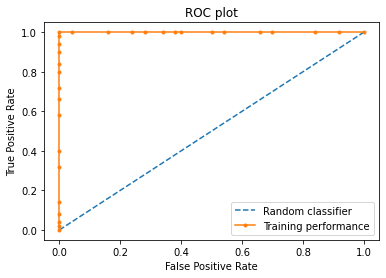

In [13]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Comparison with train-test split 


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    Outcome_vector, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [16]:
## Step 1: defining the model
ML_model = RandomForestClassifier()

## Step 2: training the model with the data we prepared
ML_model.fit(X_train, y_train)

## Step 3: evaluation
y_prob=ML_model.predict_proba(X_test)

prediction_check = pd.DataFrame({'True label':y_test,
                                'Probability': y_prob[:,1]})


fpr_test, tpr_test, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

prediction_check


,True label,Probability
0,1,0.43
1,1,0.50
2,0,0.37
3,1,0.53
4,0,0.61
5,1,0.45
6,0,0.49
7,0,0.41
8,0,0.53
9,0,0.44


### Comparison with cross validation

In [17]:
from sklearn.model_selection import KFold

In [18]:
k = 10
kf = KFold(n_splits=k)
ML_model = RandomForestClassifier()


Cross_val_list = []

 
for train_index , test_index in kf.split(data):
    X_train , X_test = data.iloc[train_index,:],data.iloc[test_index,:]
    y_train , y_test = np.take(Outcome_vector, train_index) == 1 , np.take(Outcome_vector, test_index) == 1
     
    ML_model.fit(X_train,y_train)
    
    y_prob = ML_model.predict_proba(X_test)
    

    Cross_val_list.append(
        pd.DataFrame({
            'True label': y_test,
            'Probability':  y_prob[:,1]
        })
    )

Cross_val_results = pd.concat(Cross_val_list)
fpr_CV, tpr_CV, thresh = metrics.roc_curve(Cross_val_results['True label'] == 1, Cross_val_results['Probability'])

Cross_val_results

,True label,Probability
0,False,0.55
1,True,0.49
2,False,0.50
3,True,0.51
4,False,0.41
...,...,...
5,True,0.46
6,False,0.46
7,True,0.57
8,False,0.49


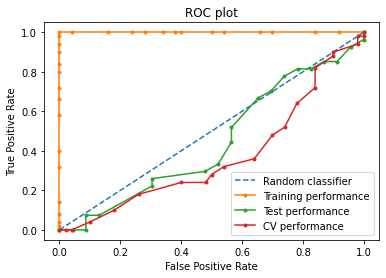

In [19]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
plt.plot(fpr_CV, tpr_CV, marker='.', label='CV performance')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Discussion

As we would expect, if we do this correctly then a model trained on random data is not able to predict other random data. 

## 3.2 Data leakage caused by signal (pre-) processing

This form of data leakage is the most difficult to detect, which also makes it the most prevalent. This data leak has to do with an improper train-test split. It is not sufficient to train your model on a part of the data and evaluate the model on an other part. It is even necessary to do all pre-processing based on **just the training data**. Lets illustrate this by taking the train test setup from above.

However, first we are going to do a feature selection step to get rid of some of the variables so that the final model is smaller. 

In [20]:
from sklearn.feature_selection import SelectKBest
data_selected = SelectKBest(k=25).fit_transform(data, Outcome_vector)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_selected, 
                                                    Outcome_vector, 
                                                    random_state=42)


In [22]:
data_selected.shape

(100, 25)

In [23]:
len(Outcome_vector)

100

In [24]:
## Step 1: defining the model
ML_model = RandomForestClassifier()

## Step 2: training the model with the data we prepared
ML_model.fit(X_train, y_train)

## Step 3: evaluation
y_prob=ML_model.predict_proba(X_test)

prediction_check = pd.DataFrame({'True label':y_test,
                                'Probability': y_prob[:,1]})


fpr_test_feat_sel, tpr_test_feat_sel, thresh = metrics.roc_curve(prediction_check['True label'] == 1, prediction_check['Probability'])

prediction_check

,True label,Probability
0,1,0.76
1,1,0.40
2,0,0.27
3,1,0.57
4,0,0.38
5,1,0.73
6,0,0.31
7,0,0.45
8,0,0.49
9,0,0.49


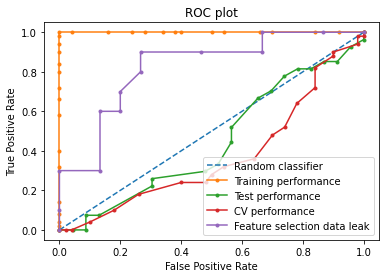

In [25]:
plt.plot([0,1], [0,1], linestyle='--', label='Random classifier')
plt.plot(fpr_training, tpr_training, marker='.', label='Training performance')
plt.plot(fpr_test, tpr_test, marker='.', label='Test performance')
plt.plot(fpr_CV, tpr_CV, marker='.', label='CV performance')
plt.plot(fpr_test_feat_sel, tpr_test_feat_sel, marker='.', label='Feature selection data leak')
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
